# Pathway Enrichment of LR loadings

Cell-cell communication inference from single-cell data provides unprecedented insights into the molecular mechanisms underlying cell-cell communication. In particular, it enables the capture of CCC interactions at a systems level, which is not possible with traditional approaches. However, as the number of inferred interactions increases, the interpretation of the inferred cell-cell communication networks becomes more challenging. To this end, as done in other omics studies, we can perform pathway enrichment analysis to identify the general biological processes that are enriched in the inferred interactions. Pathway enrichment thus serves two purposes; it reduces the dimensionality of the inferred interactions, and also provides a biological summary of the inferred interactions.

In this tutorial, we will show how to use the `cell2cell` and `liana` packages to perform classical gene set enrichment analysis using `GSEA` with `KEGG Pathways`, and also we will use perform a footprint enrichment analysis using a `multi-variate linear model` with the PROGENy pathway resource. We will use the [`GSEAPY`](https://gseapy.readthedocs.io/en/latest/) and [`decoupler-py`](https://decoupler-py.readthedocs.io/en/latest) packages to perform these analyses.

In [1]:
import cell2cell as c2c
import liana as li

import pandas as pd

import decoupler as dc

import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

%matplotlib inline

/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Directories

In [3]:
output_folder = '../../data/tc2c-outputs/'
c2c.io.directories.create_directory(output_folder)

../../data/tc2c-outputs/ already exists.


## Load Data

**Open the loadings obtained from the tensor factorization**

In [4]:
factors = c2c.io.load_tensor_factors(output_folder + 'Loadings.xlsx')

**Load list of ligand-receptor pairs used as reference to [run LIANA](./02-Infer-Communication-Scores.ipynb)**

In [5]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


**Generate a list with the LR pair names**

KEGG was originally designed to work with list of genes. Here we are using ligand-receptor pairs, so instead of using Gene Sets we need to build our LR-gene sets. This list is a first step to build the LR-gene sets.

In [6]:
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()] 

## Gene Set Enrichment Analysis

In this case, we will run the PreRank method of GSEA since our LR pairs are pre-ranked based on their loadings in each factor obtained by Tensor-cell2cell.

### Generate LR-gene set for running GSEA

`cell2cell` includes some resources associated with the Gene sets employed in GSEA. It includes annotations of GO Terms (BP), KEGG, and Reactome, for human and mouse.

**First, specify which organism and annotation DB to use**

In [7]:
organism = 'human' # For the COVID-19 data analyzed with LIANA+Tensor-cell2cell
pathwaydb = 'KEGG' # KEGG Pathways

**Generate the LR-gene set that will be used for running GSEA**

In [8]:
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep = '_',
                                          lr_sep = '^',
                                          organism = organism,
                                          pathwaydb = pathwaydb,
                                          readable_name = True
                                          )

100%|███████████████████████████████████████| 97.7k/97.7k [00:00<00:00, 307kB/s]


### Extract LR loadings for each factor

In [9]:
lr_loadings = factors['Ligand-Receptor Pairs']

### Run GSEA

This external function implemented in `cell2cell` builds upon the function `gseapy.prerank()`.

All outputs will be saved in the `output_folder`. Make sure that this path exist before running this function.

In [10]:
%%time
pvals, scores, gsea_df = c2c.external.run_gsea(loadings=lr_loadings, 
                                               lr_set=lr_set,
                                               output_folder=output_folder,
                                               weight=1,
                                               min_size=15,
                                               permutations=999,
                                               processes=6,
                                               random_state=6,
                                               significance_threshold=0.05,
                                              )

../../data/tc2c-outputs/ already exists.


 18%|████████                                    | 2/11 [00:01<00:07,  1.26it/s]2023-03-21 12:35:51,797 [WARNING] Duplicated values found in preranked stats: 0.28% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 27%|████████████                                | 3/11 [00:03<00:08,  1.12s/it]2023-03-21 12:35:53,303 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 36%|████████████████                            | 4/11 [00:04<00:07,  1.12s/it]2023-03-21 12:35:54,492 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 73%|████████████████████████████████            | 8/11 [00:09<00:03,  1.30s/it]2023-03-21 12:35:59,670 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce 

CPU times: user 12.5 s, sys: 136 ms, total: 12.7 s
Wall time: 11.5 s


### Visualization

We can use the `pvals` and `scores`outputs to visualize the results as a Dot Plot:

In [11]:
import numpy as np

significance = 0.05
pval_df = pvals


df = pval_df.lt(significance).astype(int)
# Drop all zeros
df = df.loc[(df != 0).any(axis=1)]
df = df.T.loc[(df != 0).any(axis=0)].T

In [12]:
pval_df[df.columns].loc[df.index].applymap(lambda x: -1. * np.log10(x + 1e-9))

Factor,Factor 3,Factor 6,Factor 7,Factor 8,Factor 11
Term,,,,,
ANTIGEN PROCESSING AND PRESENTATION,1.730720,1.730720,1.730720e+00,1.730720e+00,5.029221e-01
APOPTOSIS,1.730720,0.291580,-4.342945e-10,-4.342945e-10,1.730720e+00
CELL ADHESION MOLECULES CAMS,1.107036,1.730720,8.633457e-01,8.856221e-01,-4.342945e-10
INTESTINAL IMMUNE NETWORK FOR IGA PRODUCTION,0.108813,0.863346,-4.342945e-10,1.311156e+00,-4.342945e-10


In [13]:
pval_df

Factor,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11
Term,,,,,,,,,,
ANTIGEN PROCESSING AND PRESENTATION,0.149650,0.018590,0.136979,0.870871,0.018590,0.018590,0.018590,1.000000,0.315783,0.314107
APOPTOSIS,1.000000,0.018590,0.078156,1.000000,0.510999,1.000000,1.000000,1.000000,1.000000,0.018590
AXON GUIDANCE,0.968747,1.000000,0.870871,0.877893,0.960068,0.870871,0.968747,0.921462,0.510999,0.877393
CELL ADHESION MOLECULES CAMS,1.000000,0.078156,1.000000,1.000000,0.018590,0.136979,0.130130,1.000000,0.790076,1.000000
CHEMOKINE SIGNALING PATHWAY,0.870871,0.921462,0.884885,0.247867,0.884885,0.884885,0.959710,0.119286,1.000000,0.315783
CYTOKINE CYTOKINE RECEPTOR INTERACTION,1.000000,1.000000,1.000000,0.968747,0.924791,0.968747,1.000000,0.266175,0.290290,1.000000
ECM RECEPTOR INTERACTION,0.994364,1.000000,1.000000,1.000000,1.000000,0.136979,1.000000,0.419366,0.942609,0.510999
FOCAL ADHESION,0.888917,0.968747,0.870871,0.741176,0.778371,0.290290,0.783147,0.458880,0.778371,0.778371
INTESTINAL IMMUNE NETWORK FOR IGA PRODUCTION,1.000000,0.778371,0.968747,0.778371,0.136979,1.000000,0.048848,0.419366,1.000000,1.000000


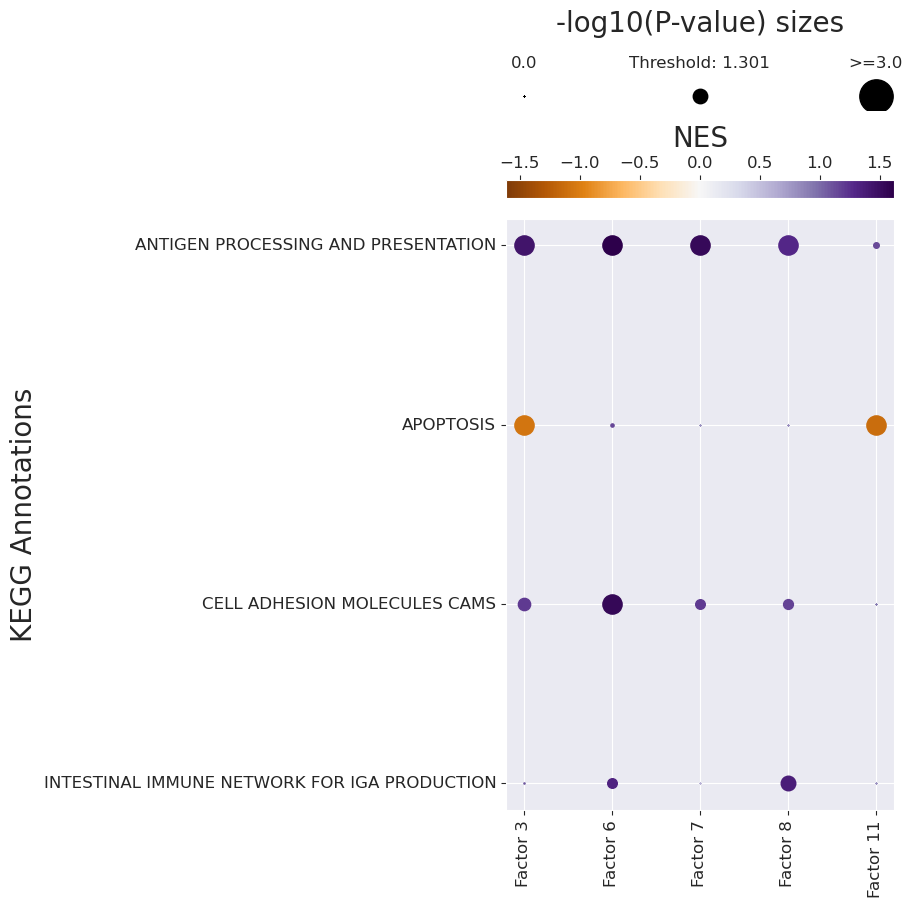

In [14]:
with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pvals,
                                                       score_df=scores,
                                                       significance=0.05,
                                                       xlabel='',
                                                       ylabel='{} Annotations'.format(pathwaydb),
                                                       cbar_title='NES',
                                                       cmap='PuOr',
                                                       figsize=(5, 10),
                                                       label_size=20,
                                                       title_size=20,
                                                       tick_size=12,
                                                       filename=output_folder + '/GSEA-Dotplot.pdf'
                                                      )

**Similarly, we can use gsea_df to easily see the Enriched Pathways**

In [15]:
gsea_df.loc[(gsea_df['Adj. P-value'] < 0.05) & (gsea_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
13,Factor 3,ANTIGEN PROCESSING AND PRESENTATION,1.441494,0.001000,0.018590
52,Factor 6,ANTIGEN PROCESSING AND PRESENTATION,1.615916,0.001000,0.018590
53,Factor 6,CELL ADHESION MOLECULES CAMS,1.547076,0.001000,0.018590
65,Factor 7,ANTIGEN PROCESSING AND PRESENTATION,1.537889,0.001000,0.018590
78,Factor 8,INTESTINAL IMMUNE NETWORK FOR IGA PRODUCTION,1.368692,0.003006,0.048848
79,Factor 8,ANTIGEN PROCESSING AND PRESENTATION,1.299828,0.001001,0.018590


**And Depleted Pathways**

In [16]:
gsea_df.loc[(gsea_df['Adj. P-value'] < 0.05) & (gsea_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value
17,Factor 3,APOPTOSIS,-1.062030,0.001,0.01859
120,Factor 11,APOPTOSIS,-1.132762,0.001,0.01859


## Footprint Enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity [(Dugourd and Saez-Rodriguez, 2019)](https://www.sciencedirect.com/science/article/pii/S2452310019300149). This is particularly useful when working with transcriptomics data, as it allows to identify the genes that are regulated by a biological process, instead of the genes that are part of the process. In this case, we will use the PROGENy pathway resource to perform footprint enrichment analysis. PROGENy was built in a data-driven manner using perturbation and cancer lineage data [(Schubert et al, 2019)](https://www.nature.com/articles/s41467-017-02391-6#Sec8), as a consequence it also assigns different importances or weights to each gene in its pathway genesets.

To this end, we need an enrichment method that can take weights into account, and here we will use multi-variate linear models from the `decoupler-py` package to perform this analysis [(Badia-i-Mompel et al., 2022)](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613).

###  load the PROGENy pathway resource:

In [17]:
net = dc.get_progeny(organism='human', top=5000)

Now we will use the PROGENy genesets to assign pathways and weights to the ligand-receptor pairs in liana's consensus resource. Specifically, we will use the weighted bipartite networks from PROGENy, where the weight represents the importance of the genes to a given geneset, and assign a weight to each ligand-receptor interaction, based on the mean of the weights of the proteins in that ligand-receptor interaction. We keep only ligand-receptor weights only if all the protein in the ligand-receptor interaction are present for a given pathway, and are sign-coherent.

In [18]:
lr_progeny = li.funcomics.generate_lr_geneset(lr_pairs, net, lr_separator="^")
lr_progeny.head()

,source,interaction,weight
1,JAK-STAT,LGALS9^PTPRC,1.307807
74,Androgen,SEMA4D^MET,-0.831693
90,Androgen,HGF^MET,-1.288956
106,Androgen,TIMP3^MET,-1.122612
151,NFkB,SELE^CD44,3.332552


### Run footprint enrichment analysis

We will now use the `decoupler-py` package to perform the analysis.

In [19]:
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(), 
                              lr_progeny, 
                              source="source", 
                              target="interaction", 
                              use_raw=False)

### Visualize Results

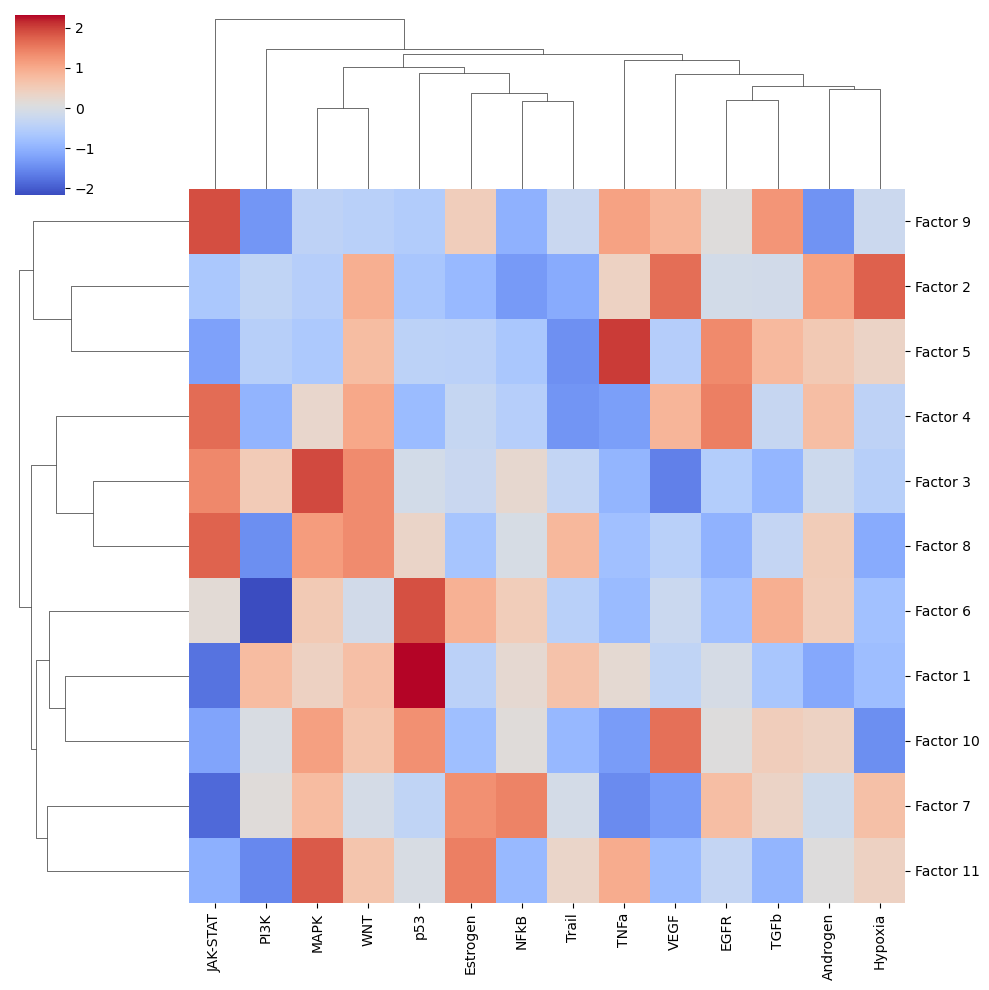

In [20]:
sns.clustermap(estimate, xticklabels=estimate.columns, cmap='coolwarm', z_score=4)
plt.savefig(output_folder + '/PROGENy.pdf', dpi=300, bbox_inches='tight')

Let's zoom in on Factor <span style='color:red'>**XXX**</span>, which is associated with COVID-19 cases. 

<font color='red'>Need to adjust this selected factor and discussion here and in Tutorial 5 according to new results</font>

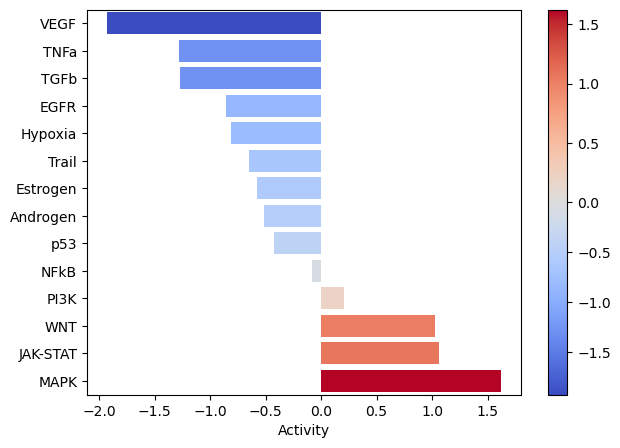

In [23]:
selected_factor = 'Factor 3'

dc.plot_barplot(estimate,
                selected_factor,
                vertical=True, 
                cmap='coolwarm', 
                save=output_folder + '/PROGENy-{}.pdf'.format(selected_factor.replace(' ', '-')))

<font color='red'>Adjust</font>:From the plots above, we can see that the MAPK pathway is active and highly active in Factor 6. This is also concordant with the KEGG pathways associated with the chemokine and cytotoxic response from the analysis with GSEA above. Indeed, the tensor decomposition results indicate that NKs and T cells are the main sender cells in this factor. So, let's see which ligand-receptor pairs are enriched in this pathway.

In [24]:
# loadings to long format
lr_loadings_long = lr_loadings.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
# join progeny weights and keep only NFkB pathway
lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == 'NFkB' and Factor == '{}'".format(selected_factor))
# add sign to the weights
lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
# keep only relevant interactions for labels
lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.025) and (x['weight'] > 2.5) else None, axis=1)
lr_loadings_long.head()

,interaction,Factor,Loadings,source,weight,sign,relevant_interactions
163,ADAM17^ITGA5,Factor 3,7.159039e-15,NFkB,1.961245,positive,None
227,ADAM17^MUC1,Factor 3,9.888107e-03,NFkB,1.680033,positive,None
268,ADAM17^RHBDF2,Factor 3,3.606098e-03,NFkB,2.274298,positive,None
332,ADM^GPR84,Factor 3,3.490119e-02,NFkB,5.392048,positive,ADM^GPR84
882,B2M^LILRB1,Factor 3,8.364470e-02,NFkB,1.465579,positive,None


#### plot the loadings for Factor <font color='red'>xxx</font> and weights of the NFkB pathway

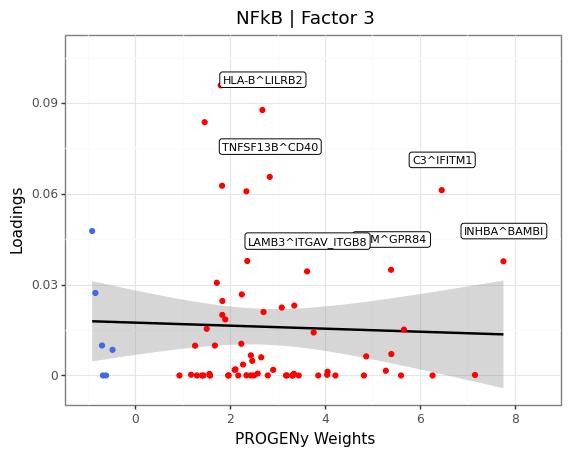

<ggplot: (8788956784280)>

In [25]:
(p9.ggplot(lr_loadings_long,
           p9.aes(x='weight', y='Loadings')) +
 p9.geom_smooth(method='lm') + 
 p9.geom_point(p9.aes(colour='sign')) +
 p9.theme_bw() +
 p9.theme(legend_position='none') +
 p9.labs(title="NFkB | {}".format(selected_factor), x="PROGENy Weights", y="Loadings") +
 p9.scale_colour_manual(values=["royalblue", "red"]) +
 p9.geom_label(p9.aes(label='relevant_interactions'), size=8, nudge_y=0.01, nudge_x=0.01) + 
 p9.xlim(-1, 8.5)
 )

Here, we can see that for example the `C3 -> IFITM1` and `VEGFA -> CD44` are interactions found with high importances in the NFkB pathway, and high loadings. Also IFITM1 is involved in restricting viral infection (https://doi.org/10.15252/embj.2020106501), which in this case could represent the immune response controling the SARS-CoV-2 infection.